In [1]:
from tensorflow.keras.layers import Dense, Input, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [2]:
batch_size = 64
width, height, channel = 400, 400, 3
epochs = 30
input_shape = (width, height, channel)

In [3]:
# pretrained된 VGG16모델을 가져온다.
# https://keras.io/api/applications/vgg/#vgg16-function
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None
)

In [4]:
pretrained_model.trainable = False    # VGG16의 가중치들은 학습이 이루어지지 않도록 한다

model = Sequential()

# CAM을 위해 하단에 다른 레이어를 추가해야하기 때문에 VGG16의 맨 마지막 레이어(pooling layer)를 제외하고 나머지 레이어를 model에 추가해준다
for layer in pretrained_model.layers[:-1]:
    model.add(layer)

# CAM을 구현하기 위해 Conv2D, GlobalAveragePolling2D, Dense 레이어를 추가해준다
model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

metrics = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=metrics)

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 100, 100, 256)     2

In [6]:
# 데이터 가져오기
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
train_generator = datagen.flow_from_directory('preprocessed_data/train',
                                                    target_size=(400, 400),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

valid_generator = datagen.flow_from_directory('preprocessed_data/train',
                                                    target_size=(400, 400),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='validation')

test_generator = datagen.flow_from_directory('preprocessed_data/test',
                                                    target_size=(400, 400),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = valid_generator, 
        validation_steps = valid_generator.samples // batch_size,
        epochs = epochs,
        callbacks=[callback])

Found 1953 images belonging to 2 classes.
Found 650 images belonging to 2 classes.
Found 650 images belonging to 2 classes.
Epoch 1/30
30/30 [==============================] - 24s 811ms/step - loss: 0.7846 - tp: 1149.0000 - fp: 740.0000 - tn: 1149.0000 - fn: 740.0000 - accuracy: 0.6083 - precision: 0.6083 - recall: 0.6083 - auc: 0.6332 - val_loss: 0.5552 - val_tp: 463.0000 - val_fp: 177.0000 - val_tn: 463.0000 - val_fn: 177.0000 - val_accuracy: 0.7234 - val_precision: 0.7234 - val_recall: 0.7234 - val_auc: 0.8007
Epoch 2/30
30/30 [==============================] - 23s 759ms/step - loss: 0.4956 - tp: 1530.0000 - fp: 390.0000 - tn: 1530.0000 - fn: 390.0000 - accuracy: 0.7969 - precision: 0.7969 - recall: 0.7969 - auc: 0.8660 - val_loss: 0.5193 - val_tp: 451.0000 - val_fp: 189.0000 - val_tn: 451.0000 - val_fn: 189.0000 - val_accuracy: 0.7047 - val_precision: 0.7047 - val_recall: 0.7047 - val_auc: 0.8105
Epoch 3/30
30/30 [==============================] - 23s 761ms/step - loss: 0.4726 - tp

30/30 [==============================] - 23s 756ms/step - loss: 0.2158 - tp: 1747.0000 - fp: 173.0000 - tn: 1747.0000 - fn: 173.0000 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9740 - val_loss: 0.1997 - val_tp: 593.0000 - val_fp: 47.0000 - val_tn: 593.0000 - val_fn: 47.0000 - val_accuracy: 0.9266 - val_precision: 0.9266 - val_recall: 0.9266 - val_auc: 0.9762
Epoch 22/30
30/30 [==============================] - 23s 765ms/step - loss: 0.2027 - tp: 1723.0000 - fp: 166.0000 - tn: 1723.0000 - fn: 166.0000 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9761 - val_loss: 0.1796 - val_tp: 601.0000 - val_fp: 39.0000 - val_tn: 601.0000 - val_fn: 39.0000 - val_accuracy: 0.9391 - val_precision: 0.9391 - val_recall: 0.9391 - val_auc: 0.9820
Epoch 23/30
30/30 [==============================] - 23s 767ms/step - loss: 0.2048 - tp: 1732.0000 - fp: 157.0000 - tn: 1732.0000 - fn: 157.0000 - accuracy: 0.9169 - precision: 0.9169 - recall: 0.9169 - auc: 0.9762 - val_los

In [7]:
model.evaluate(test_generator)

11/11 [==============================] - 6s 514ms/step - loss: 0.1413 - tp: 617.0000 - fp: 33.0000 - tn: 617.0000 - fn: 33.0000 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9881


[0.14133046567440033,
 617.0,
 33.0,
 617.0,
 33.0,
 0.9492307901382446,
 0.9492307901382446,
 0.9492307901382446,
 0.9880923628807068]

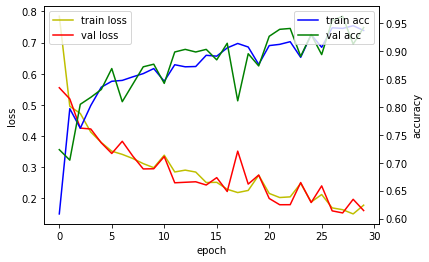

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

| model | test_precision | test_recall | test_auc | test_accuracy |
|---|
| VGG16 | 0.9833 | 0.9219 | 0.9889 | 0.9538 |

| Hypermeters | Values |
|---|
| Epoch | 20 |
| Batch Size | 64
| Train Validation Test ratio | 6:2:2 |
| Optimizer | Adam |
| Input size | (400, 400, 3) |

|  |  |
|---|
| TP=295 | FN=25 |
| FP=5 | TN=325 |

In [56]:
# 참고
# https://dryjelly.tistory.com/147
# https://github.com/jacobgil/keras-cam/blob/master/cam.py

index = 5

import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])    # 이미지 입력을 받아 model의 마지막에 추가한 Conv2D와 Dense 레이어를 출력하는 모델
[conv_outputs, predictions] = get_output(np.array([test_generator[0][0][index]]))                # 이미지 입력
conv_outputs = conv_outputs[0, :, :, :]

class_weights = model.layers[-1].get_weights()[0]    # model의 맨 마지막 레이어인 Dense 레이어의 weight를 가져온다

cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
for i, w in enumerate(class_weights[:, 1]):
        cam += w * conv_outputs[:, :, i]    # 마지막 레이어의 각 가중치와 Conv2D의 결과를 곱하여 누적하여 가산 -> CAM 구현

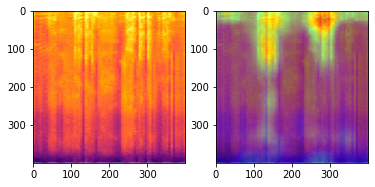

In [57]:
# 결과 이미지를 보기 좋게 가공

# CAM 이미지의 값 범위를 0 부터 255까지로 맞추고
# 이미지 크기를 원본 데이터와 일치하도록 resize한다
heatmap = cam
heatmap = heatmap / (np.max(heatmap) - np.min(heatmap)) * 255.9
heatmap = -heatmap + 256
heatmap = np.uint8(heatmap - np.min(heatmap))
heatmap = cv2.resize(heatmap, (height, width))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 원본 이미지도 비슷하게 처리
origin_img = test_generator[0][0][index]
origin_img = origin_img / (np.max(origin_img) - np.min(origin_img)) * 255.9
origin_img = np.uint8(origin_img - np.min(origin_img))
plt.subplot(1, 2, 1)
plt.imshow(origin_img)

# 원본 이미지와 CAM 합성
a = 0.6
dst = cv2.addWeighted(origin_img, a, heatmap, 1 - a, 0)
plt.subplot(1, 2, 2)
plt.imshow(dst)